<font size="6"><b>MLP Neural Networks - Part I</b></font>

# Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPool2D, Flatten , Dropout , BatchNormalization
from keras import Sequential
from keras.layers import Dense
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras

# Data Loading

In [2]:
dfm_ready = pd.read_csv('dfm_ready.csv', index_col=0)
dfm_ready.head().append(dfm_ready.tail())

,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,15.0,3,3,10.0,-23.0,268.0,225.0,1605.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,2,3,7.0,-24.0,99.0,65.0,414.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,3,3,5.0,-13.0,134.0,106.0,846.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,3,3,6.0,-2.0,190.0,157.0,1120.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,-3.0,14.0,2,2,6.0,-16.0,206.0,173.0,1222.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7213439,31.0,12.0,4,4,6.0,9.0,182.0,142.0,1303.0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213440,-1.0,12.0,3,3,4.0,-23.0,84.0,46.0,331.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213441,-4.0,20.0,3,3,7.0,-5.0,100.0,72.0,331.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213442,6.0,18.0,4,4,10.0,1.0,181.0,148.0,936.0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213445,8.0,8.0,3,3,7.0,-4.0,71.0,44.0,130.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


The next cell will make sure that all my features are in floating format, followed by a double check with the .info() function

In [3]:
dfm_ready.drop(['TAXI_OUT','WHEELS_OFF','WHEELS_ON','DAY','TAXI_IN','ARR_DELAY'], axis=1, inplace=True)

In [4]:
df = dfm_ready.astype(float)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982067 entries, 0 to 7213445
Data columns (total 64 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   DEP_DELAY                      float64
 1   CRS_ELAPSED_TIME               float64
 2   AIR_TIME                       float64
 3   DISTANCE                       float64
 4   FLIGHT_STATUS                  float64
 5   OP_CARRIER_Allegiant Air       float64
 6   OP_CARRIER_American Airlines   float64
 7   OP_CARRIER_Delta Airlines      float64
 8   OP_CARRIER_Endeavor Air        float64
 9   OP_CARRIER_Envoy Air           float64
 10  OP_CARRIER_ExpressJet          float64
 11  OP_CARRIER_Frontier Airlines   float64
 12  OP_CARRIER_Hawaiian Airlines   float64
 13  OP_CARRIER_JetBlue Airways     float64
 14  OP_CARRIER_Mesa Airline        float64
 15  OP_CARRIER_PSA Airlines        float64
 16  OP_CARRIER_Republic Airways    float64
 17  OP_CARRIER_SkyWest Airlines    float64
 18  OP

==================================================================================

# Function Library

This is a quick parenthesis to write down a few functions that I will be using to evaluate every model once finish training it. 

In [6]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('LOSS', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('ACCURACY', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.show()

In [7]:
def conf_matrix(conf_mat,):
    
    conf_mat = pd.DataFrame(conf_mat, index = ['0', '1'], columns = ['0', '1'])
    sns.set(font_scale=1.4)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_mat, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()

In [8]:
def model_metrics(a, b):
    
    accuracy = metrics.accuracy_score(a, b)
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)

    print('Accuracy:', round(accuracy*100, 2),'%')
    print('Precision score:', round(precision*100, 2),'%')
    print('Recall score:', round(recall*100, 2),'%')
    print('F1 score:', round(f1*100, 2),'%')

==================================================================================

Target (y) and Features (X) definitions:

In [9]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS', 'DEP_DELAY'], axis=1)

Notice that the models that will be trained on this Notebook have all the features available except for the FLIGHT_STATUS, which is our target, and the DEP_DELAY, to avoid biasing the model

In [10]:
df.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.0,99.0,65.0,414.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Neural Network Conditions

1. Data has to be purely numerical<br>
2. Data cannot contain missing values<br>
3. Data has to be Normalized<br>

In [11]:
df.isna().sum().sum()

0

We know the data is purely numerical and that it has no missing values, now all is needed is to normalized and we will do it by using the <b>StandardScaler</b>

In [12]:
col_names = list(df.columns)

s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

The following are the two first rows of the normalized data:

In [13]:
df_s.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-0.321391,1.529193,1.414654,1.172975,-0.768317,-0.050067,-0.436987,-0.444443,-0.181004,-0.187551,-0.160379,-0.127262,-0.036521,-0.213085,-0.160239,-0.185638,-0.21801,-0.331799,-0.408159,-0.164808,2.836956,-0.058718,-0.32781,-0.193782,-0.243678,-0.337531,-0.270339,4.024041,-0.201662,-0.246484,-0.203853,-0.241257,-0.202764,-0.279531,-0.189913,-0.188279,-0.17047,-0.212175,-0.170563,-0.212592,-0.19016,-0.789857,1.318873,-0.469791,-0.677184,1.357611,-0.666194,-0.279091,-0.301801,-0.301174,-0.307043,-0.308123,-0.312796,-0.31331,-0.298723,-0.307682,-0.297409,-0.298946,-0.409881,-0.411999,-0.417128,-0.418755,-0.371965,-0.405741
1,-0.384870,-0.705450,-0.755912,-0.730105,-0.768317,-0.050067,-0.436987,-0.444443,-0.181004,-0.187551,-0.160379,-0.127262,-0.036521,-0.213085,-0.160239,-0.185638,-0.21801,-0.331799,-0.408159,-0.164808,2.836956,-0.058718,-0.32781,-0.193782,-0.243678,-0.337531,-0.270339,-0.248506,-0.201662,-0.246484,-0.203853,-0.241257,-0.202764,-0.279531,-0.189913,-0.188279,-0.17047,-0.212175,-0.170563,4.703843,-0.19016,1.266053,-0.758223,-0.469791,-0.677184,1.357611,-0.666194,-0.279091,-0.301801,-0.301174,-0.307043,-0.308123,-0.312796,-0.31331,-0.298723,-0.307682,-0.297409,-0.298946,-0.409881,-0.411999,-0.417128,-0.418755,-0.371965,-0.405741


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

## Model 1

In [15]:
model_1 = Sequential()

model_1.add(Dense(30, activation='tanh', input_shape=(62,)))

model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1890      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


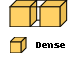

In [17]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model_1, legend=True)

In [25]:
from ann_visualizer.visualize import ann_viz
ann_viz(model_1, title="Model 1")

In [22]:
%load_ext tensorboard
from datetime import datetime
from tensorflow import keras
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
results1 = model_1.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1,callbacks=[tensorboard_callback])

Epoch 1/5
89597/89597 [==============================] - 92s 1ms/step - loss: 0.6142 - accuracy: 0.6754 - val_loss: 0.6056 - val_accuracy: 0.6879
Epoch 2/5
89597/89597 [==============================] - 103s 1ms/step - loss: 0.6115 - accuracy: 0.6761 - val_loss: 0.6123 - val_accuracy: 0.6796
Epoch 3/5
89597/89597 [==============================] - 92s 1ms/step - loss: 0.6107 - accuracy: 0.6768 - val_loss: 0.6072 - val_accuracy: 0.6743
Epoch 4/5
89597/89597 [==============================] - 95s 1ms/step - loss: 0.6107 - accuracy: 0.6772 - val_loss: 0.6061 - val_accuracy: 0.6818
Epoch 5/5
89597/89597 [==============================] - 94s 1ms/step - loss: 0.6102 - accuracy: 0.6775 - val_loss: 0.6106 - val_accuracy: 0.6797


In [24]:
%tensorboard --logdir {logs_base_dir}

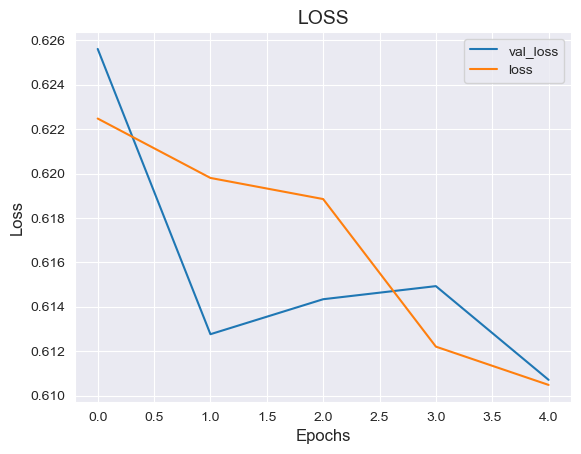

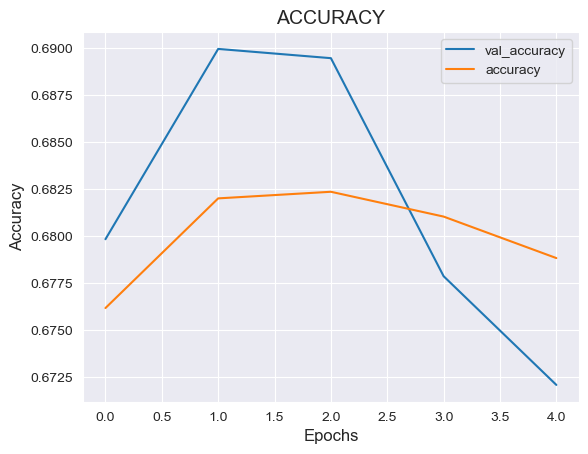

In [31]:
visualize_training_results(results1)

In [32]:
y_pred_m1 = model_1.predict(X_test)
y_pred_m1 =(y_pred_m1 > 0.5)

24888/24888 [==============================] - 14s 568us/step


In [35]:
cm_m1 = confusion_matrix(y_test, y_pred_m1)
print(cm_m1)
print("------------------")
print(classification_report(y_test, y_pred_m1))

[[494287   6546]
 [255089  40492]]
------------------
              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79    500833
         1.0       0.86      0.14      0.24    295581

    accuracy                           0.67    796414
   macro avg       0.76      0.56      0.51    796414
weighted avg       0.73      0.67      0.58    796414



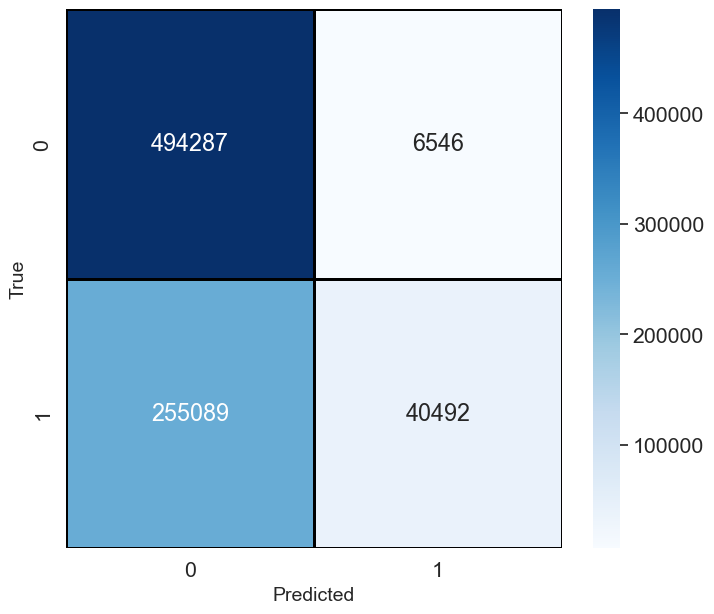

In [36]:
conf_matrix(cm_m1)

In [37]:
model_metrics(y_test, y_pred_m1)

Accuracy: 67.15 %
Precision score: 86.08 %
Recall score: 13.7 %
F1 score: 23.64 %


## Model 2

In [38]:
model_2 = Sequential()

model_2.add(Dense(30, activation='tanh', input_shape=(62,)))

model_2.add(Dense(10, activation='tanh'))

model_2.add(Dense(1, activation='sigmoid'))

In [39]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
results2 = model_2.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
89597/89597 [==============================] - 81s 887us/step - loss: 0.6187 - accuracy: 0.6798 - val_loss: 0.6066 - val_accuracy: 0.6874
Epoch 2/5
89597/89597 [==============================] - 75s 833us/step - loss: 0.6117 - accuracy: 0.6808 - val_loss: 0.6131 - val_accuracy: 0.6827
Epoch 3/5
89597/89597 [==============================] - 71s 794us/step - loss: 0.6100 - accuracy: 0.6797 - val_loss: 0.6009 - val_accuracy: 0.6881
Epoch 4/5
89597/89597 [==============================] - 71s 794us/step - loss: 0.6088 - accuracy: 0.6793 - val_loss: 0.6075 - val_accuracy: 0.6880
Epoch 5/5
89597/89597 [==============================] - 71s 794us/step - loss: 0.6094 - accuracy: 0.6777 - val_loss: 0.6138 - val_accuracy: 0.6607


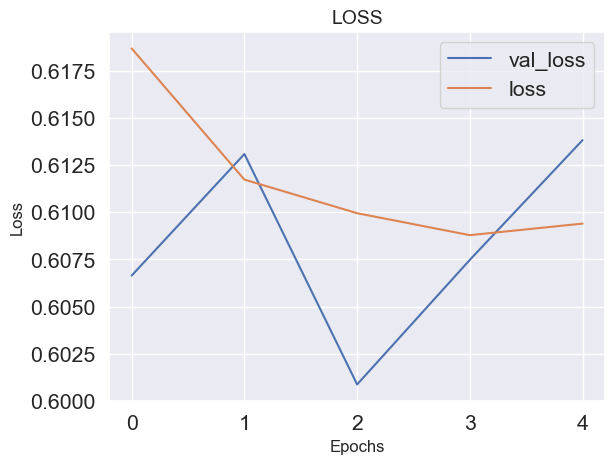

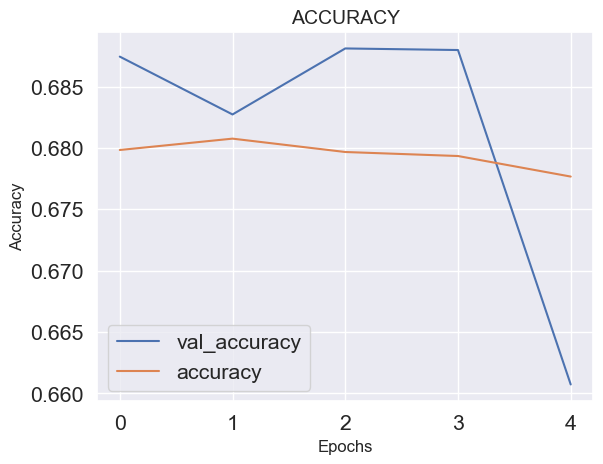

In [41]:
visualize_training_results(results2)

In [42]:
y_pred_m2 = model_2.predict(X_test)
y_pred_m2 =(y_pred_m1 > 0.5)

24888/24888 [==============================] - 14s 543us/step


In [43]:
cm_m2 = confusion_matrix(y_test, y_pred_m2)
print(cm_m2)
print("------------------")
print(classification_report(y_test, y_pred_m2))

[[494287   6546]
 [255089  40492]]
------------------
              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79    500833
         1.0       0.86      0.14      0.24    295581

    accuracy                           0.67    796414
   macro avg       0.76      0.56      0.51    796414
weighted avg       0.73      0.67      0.58    796414



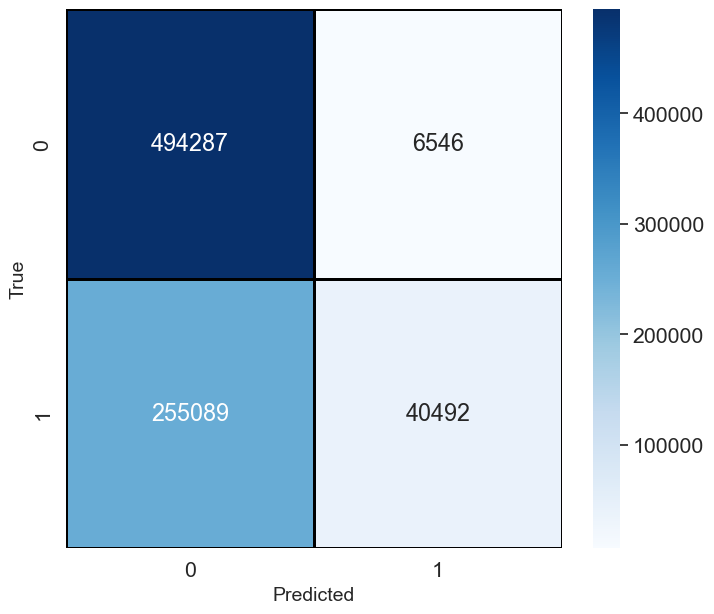

In [44]:
conf_matrix(cm_m1)

In [45]:
model_metrics(y_test, y_pred_m2)

Accuracy: 67.15 %
Precision score: 86.08 %
Recall score: 13.7 %
F1 score: 23.64 %


## Model 3

In [46]:
model_3 = Sequential()

model_3.add(Dense(30, activation='relu', input_shape=(62,)))

model_3.add(Dense(10, activation='relu'))

model_3.add(Dense(5, activation='relu'))

model_3.add(Dense(1, activation='sigmoid'))

In [47]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
results3 = model_3.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
89597/89597 [==============================] - 75s 827us/step - loss: 0.6066 - accuracy: 0.6815 - val_loss: 0.5888 - val_accuracy: 0.6927
Epoch 2/5
89597/89597 [==============================] - 74s 822us/step - loss: 0.5909 - accuracy: 0.6902 - val_loss: 0.5863 - val_accuracy: 0.6944
Epoch 3/5
89597/89597 [==============================] - 73s 819us/step - loss: 0.5886 - accuracy: 0.6915 - val_loss: 0.5864 - val_accuracy: 0.6939
Epoch 4/5
89597/89597 [==============================] - 74s 821us/step - loss: 0.5874 - accuracy: 0.6925 - val_loss: 0.5834 - val_accuracy: 0.6962
Epoch 5/5
89597/89597 [==============================] - 73s 819us/step - loss: 0.5865 - accuracy: 0.6934 - val_loss: 0.5861 - val_accuracy: 0.6935


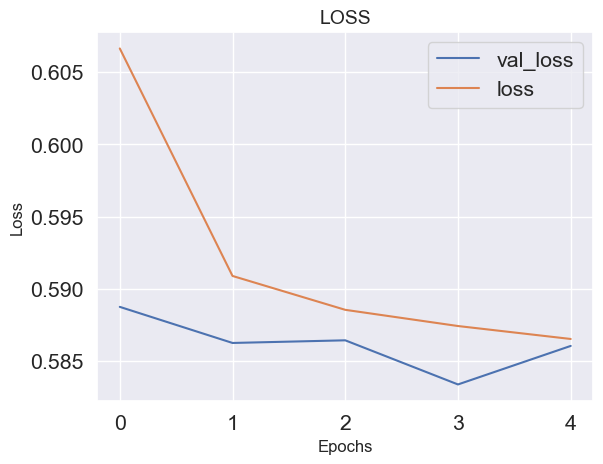

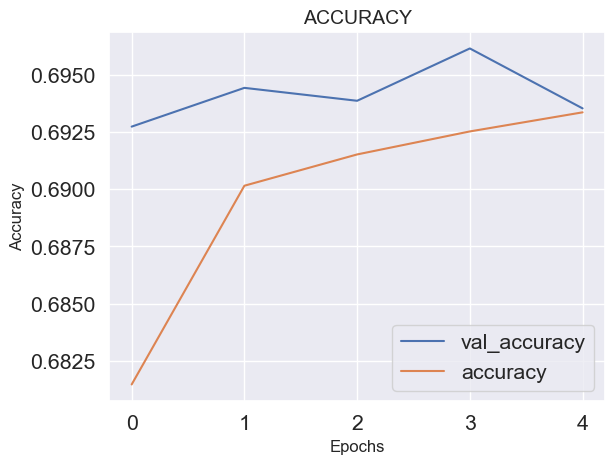

In [49]:
visualize_training_results(results3)

In [50]:
y_pred_m3 = model_3.predict(X_test)
y_pred_m3 =(y_pred_m3 > 0.5)

24888/24888 [==============================] - 14s 561us/step


In [51]:
cm_m3 = confusion_matrix(y_test, y_pred_m3)
print(cm_m3)
print("------------------")
print(classification_report(y_test, y_pred_m3))

[[470120  30713]
 [214349  81232]]
------------------
              precision    recall  f1-score   support

         0.0       0.69      0.94      0.79    500833
         1.0       0.73      0.27      0.40    295581

    accuracy                           0.69    796414
   macro avg       0.71      0.61      0.60    796414
weighted avg       0.70      0.69      0.65    796414



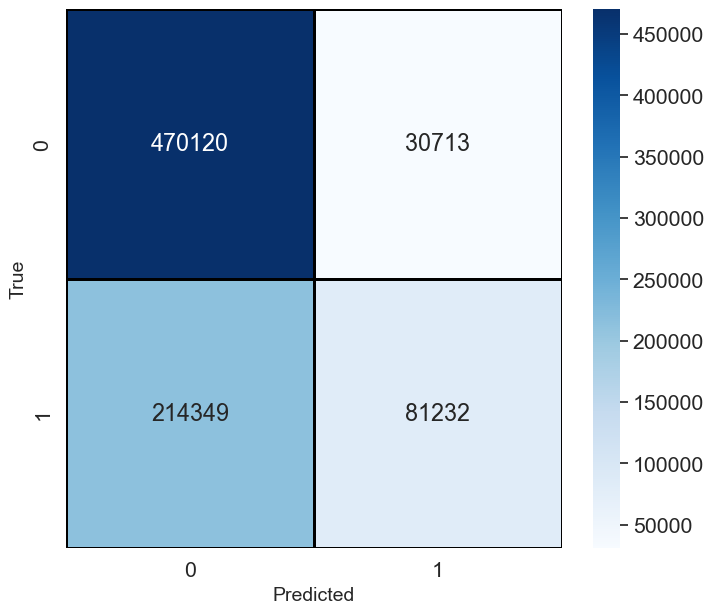

In [52]:
conf_matrix(cm_m3)

In [53]:
model_metrics(y_test, y_pred_m3)

Accuracy: 69.23 %
Precision score: 72.56 %
Recall score: 27.48 %
F1 score: 39.87 %


## Model 4

In [54]:
model_4 = Sequential()

model_4.add(Dense(30, activation='relu', input_shape=(62,)))

model_4.add(Dense(10, activation='relu'))

model_4.add(Dense(5, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))

In [55]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
results4 = model_4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
89597/89597 [==============================] - 73s 813us/step - loss: 0.6653 - accuracy: 0.6284 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 2/10
89597/89597 [==============================] - 72s 807us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 3/10
89597/89597 [==============================] - 72s 803us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 4/10
89597/89597 [==============================] - 72s 805us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 5/10
89597/89597 [==============================] - 72s 803us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 6/10
89597/89597 [==============================] - 72s 804us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 7/10
89597/89597 [==============================] - 73s 812us/step - loss: 0.6596 - accuracy: 0.6287

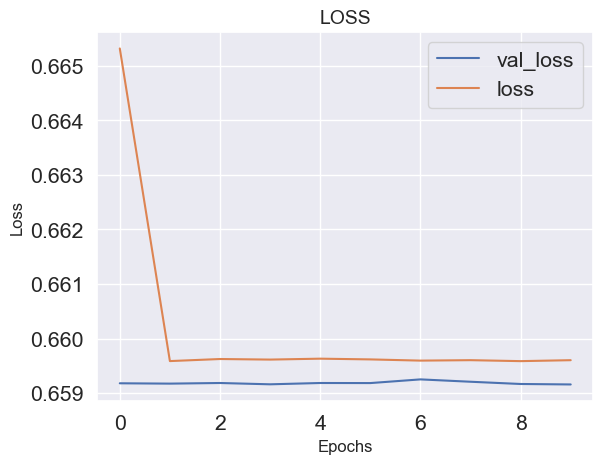

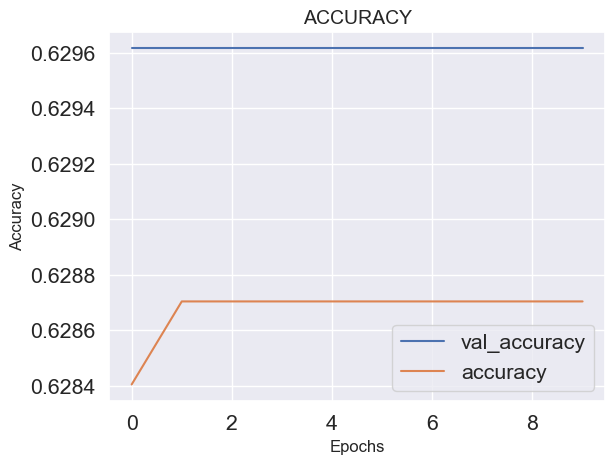

In [57]:
visualize_training_results(results4)

In [58]:
y_pred_m4 = model_4.predict(X_test)
y_pred_m4 =(y_pred_m4 > 0.5)

24888/24888 [==============================] - 14s 557us/step


In [59]:
cm_m4 = confusion_matrix(y_test, y_pred_m4)
print(cm_m4)
print("------------------")
print(classification_report(y_test, y_pred_m4))

[[500833      0]
 [295581      0]]
------------------
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77    500833
         1.0       0.00      0.00      0.00    295581

    accuracy                           0.63    796414
   macro avg       0.31      0.50      0.39    796414
weighted avg       0.40      0.63      0.49    796414



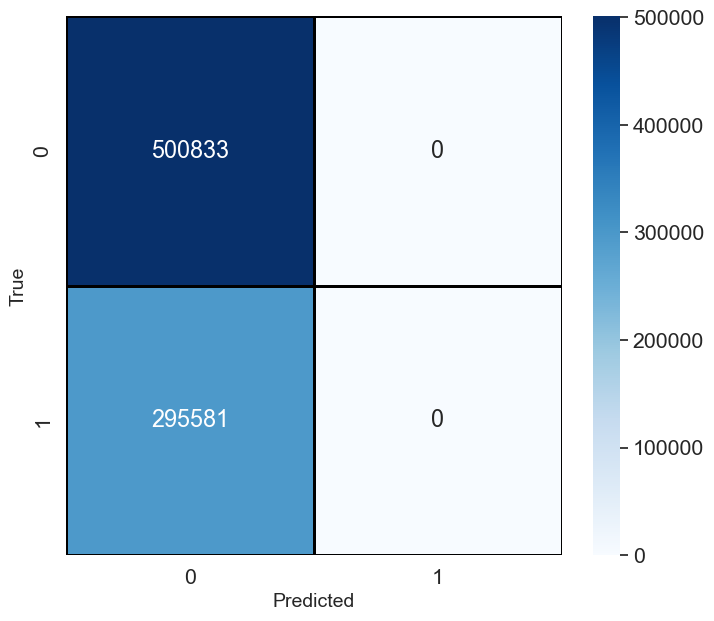

In [60]:
conf_matrix(cm_m4)

In [61]:
model_metrics(y_test, y_pred_m4)

Accuracy: 62.89 %
Precision score: 0.0 %
Recall score: 0.0 %
F1 score: 0.0 %


## Model 5

In [62]:
model_5 = Sequential()

model_5.add(Dense(30, activation='relu', input_shape=(62,)))

model_5.add(Dense(20, activation='relu'))

model_5.add(Dense(5, activation='relu'))

model_5.add(Dense(1, activation='sigmoid'))

In [63]:
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
results5 = model_5.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
89597/89597 [==============================] - 74s 817us/step - loss: 0.6690 - accuracy: 0.6286 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 2/2
89597/89597 [==============================] - 73s 819us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296


In [65]:
y_pred_m5 = model_5.predict(X_test)
y_pred_m5 =(y_pred_m1 > 0.5)

24888/24888 [==============================] - 14s 553us/step


In [66]:
cm_m5 = confusion_matrix(y_test, y_pred_m5)
print(cm_m5)
print("------------------")
print(classification_report(y_test, y_pred_m5))

[[494287   6546]
 [255089  40492]]
------------------
              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79    500833
         1.0       0.86      0.14      0.24    295581

    accuracy                           0.67    796414
   macro avg       0.76      0.56      0.51    796414
weighted avg       0.73      0.67      0.58    796414



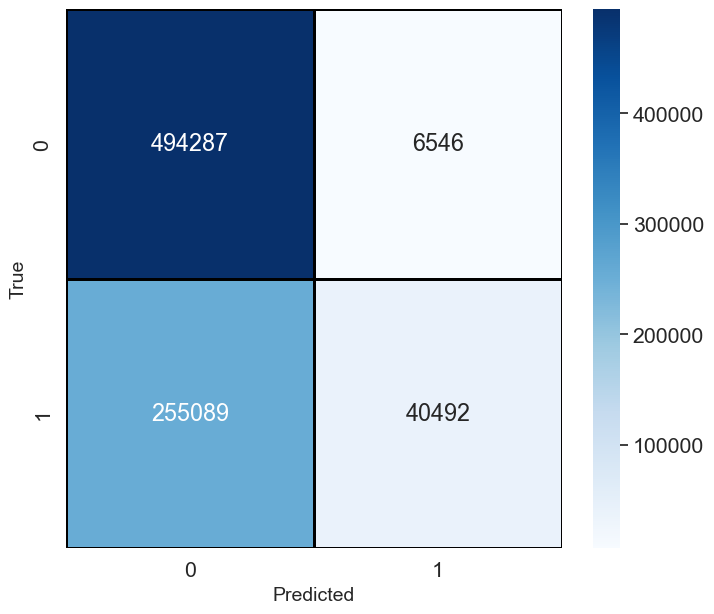

In [67]:
conf_matrix(cm_m5)

In [68]:
model_metrics(y_test, y_pred_m5)

Accuracy: 67.15 %
Precision score: 86.08 %
Recall score: 13.7 %
F1 score: 23.64 %


## Model 6

In [69]:
model_6 = Sequential()

model_6.add(Dense(50, activation='relu', input_shape=(62,)))

model_6.add(Dense(40, activation='relu'))

model_6.add(Dense(30, activation='relu'))

model_6.add(Dense(5, activation='relu'))

model_6.add(Dense(1, activation='sigmoid'))

In [70]:
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
results6 = model_6.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
89597/89597 [==============================] - 78s 864us/step - loss: 0.6599 - accuracy: 0.6286 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 2/2
89597/89597 [==============================] - 80s 889us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296


In [72]:
y_pred_m6 = model_6.predict(X_test)
y_pred_m6 =(y_pred_m6 > 0.5)

24888/24888 [==============================] - 14s 574us/step


In [73]:
cm_m6 = confusion_matrix(y_test, y_pred_m6)
print(cm_m6)
print("------------------")
print(classification_report(y_test, y_pred_m6))

[[500833      0]
 [295581      0]]
------------------
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77    500833
         1.0       0.00      0.00      0.00    295581

    accuracy                           0.63    796414
   macro avg       0.31      0.50      0.39    796414
weighted avg       0.40      0.63      0.49    796414



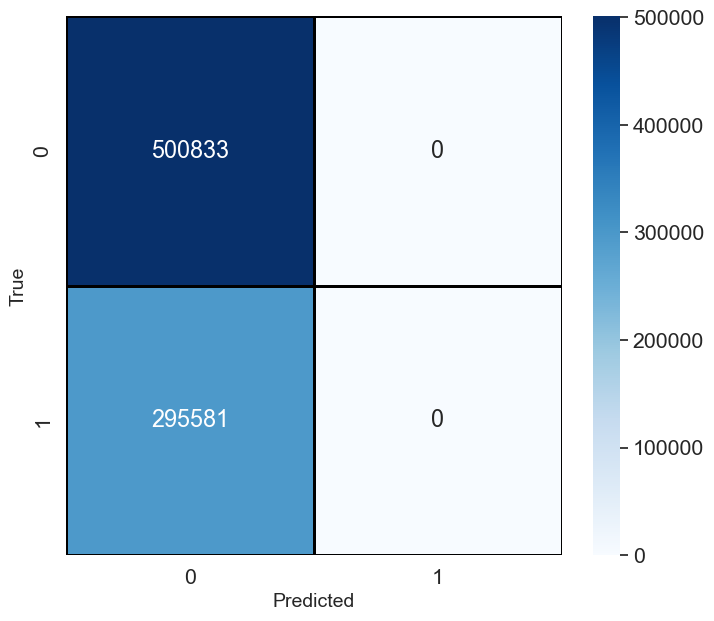

In [74]:
conf_matrix(cm_m6)

In [75]:
model_metrics(y_test, y_pred_m6)

Accuracy: 62.89 %
Precision score: 0.0 %
Recall score: 0.0 %
F1 score: 0.0 %


## Model 7

In [76]:
model_7 = Sequential()

model_7.add(Dense(30, activation='relu', input_shape=(62,)))

model_7.add(Dense(10, activation='relu'))

model_7.add(Dense(5, activation='relu'))

model_7.add(Dense(1, activation='sigmoid'))

In [77]:
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
results7 = model_7.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
89597/89597 [==============================] - 75s 831us/step - loss: 0.6111 - accuracy: 0.6791 - val_loss: 0.5941 - val_accuracy: 0.6892
Epoch 2/25
89597/89597 [==============================] - 73s 818us/step - loss: 0.5938 - accuracy: 0.6875 - val_loss: 0.5886 - val_accuracy: 0.6928
Epoch 3/25
89597/89597 [==============================] - 73s 819us/step - loss: 0.5906 - accuracy: 0.6899 - val_loss: 0.5877 - val_accuracy: 0.6928
Epoch 4/25
89597/89597 [==============================] - 74s 827us/step - loss: 0.5883 - accuracy: 0.6919 - val_loss: 0.5870 - val_accuracy: 0.6943
Epoch 5/25
89597/89597 [==============================] - 75s 837us/step - loss: 0.5874 - accuracy: 0.6927 - val_loss: 0.5844 - val_accuracy: 0.6956
Epoch 6/25
89597/89597 [==============================] - 74s 822us/step - loss: 0.5861 - accuracy: 0.6937 - val_loss: 0.5848 - val_accuracy: 0.6949
Epoch 7/25
89597/89597 [==============================] - 79s 884us/step - loss: 0.5854 - accuracy: 0.6942

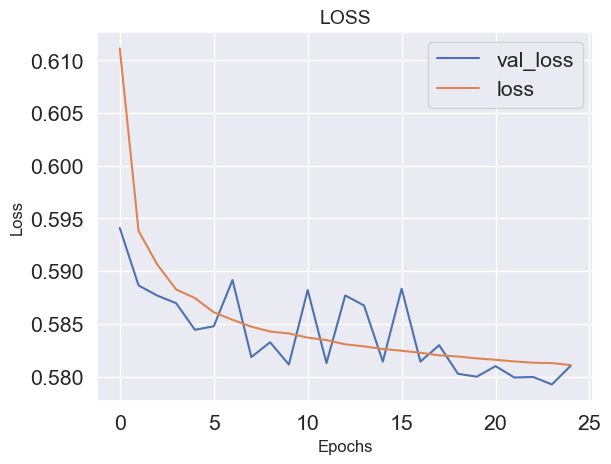

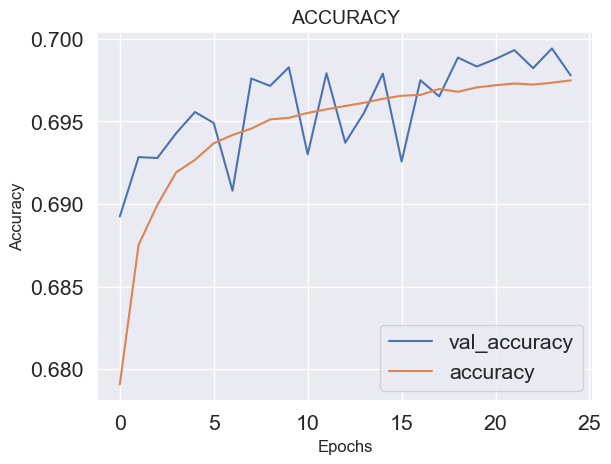

In [79]:
visualize_training_results(results7)

In [80]:
y_pred_m7 = model_7.predict(X_test)
y_pred_m7 =(y_pred_m7 > 0.5)

24888/24888 [==============================] - 14s 542us/step


In [81]:
cm_m7 = confusion_matrix(y_test, y_pred_m7)
print(cm_m7)
print("------------------")
print(classification_report(y_test, y_pred_m7))

[[446130  54703]
 [186341 109240]]
------------------
              precision    recall  f1-score   support

         0.0       0.71      0.89      0.79    500833
         1.0       0.67      0.37      0.48    295581

    accuracy                           0.70    796414
   macro avg       0.69      0.63      0.63    796414
weighted avg       0.69      0.70      0.67    796414



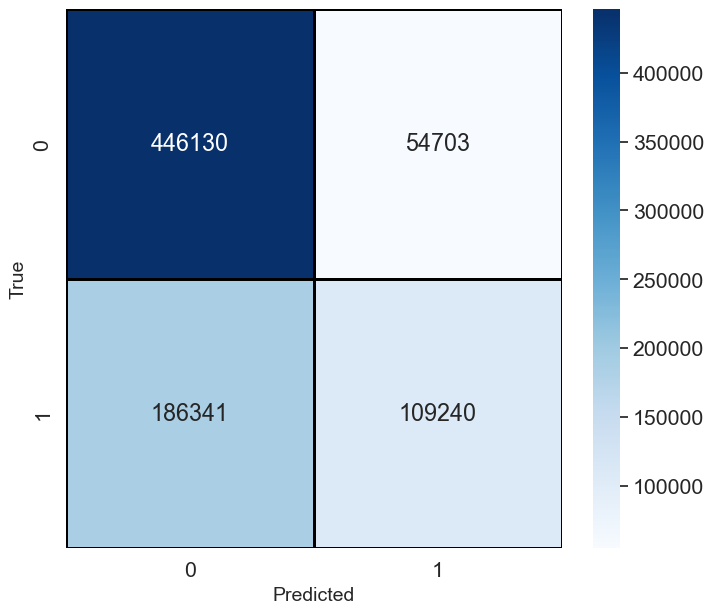

In [82]:
conf_matrix(cm_m7)

In [83]:
model_metrics(y_test, y_pred_m7)

Accuracy: 69.73 %
Precision score: 66.63 %
Recall score: 36.96 %
F1 score: 47.54 %
